# Parallelizing Aggregation Functions with Xarray and Dask

This notebooks presents an example of applying parallelized aggregation functions to earth data using `xarray` and `dask`. Aggregation function refers to computations such as mean and standard deviation. Such functions are applied along one or multiple dimensions of a dataset. This notebook covers applying them to both the spatial and temporal dimensions of a dataset with dimensions of (time, latitude, longitude).

**Who this notebook is for**
* Moderate familiarity with Python, and some basic knowledge with xarray. E.g. opening datasets, accessing and subsetting variables, applying basic functions.
* Ability to connect to AWS EC2 instances.
* Basic knowledge of parallel computing and dask clusters (if not, see a previous notebook).

**Dataset used**

Gridded sea surface temperature data with daily global coverage and 1 km spatial resolution (the MUR Level 4 daily SST ultra high resolution data product https://doi.org/10.5067/GHGMR-4FJ04). Each file represents one day and contains 2D variables corresponding to the lat/lon dimensions. Data will be accessed directly in the cloud from the AWS S3 location `s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/`. The notebook as published here uses 365 files which amounts to ~270 GB of data. This can be modified as desired.

**Analysis overview**

This analysis uses the most recent 3 years of MUR Level 4 data and loads data from one out of every 3 files (e.g. thin out the data from daily frequency to once per 3 days). SST and SST anomaly variables are subsetted to the following regions before time/spatial means are taken over each: 

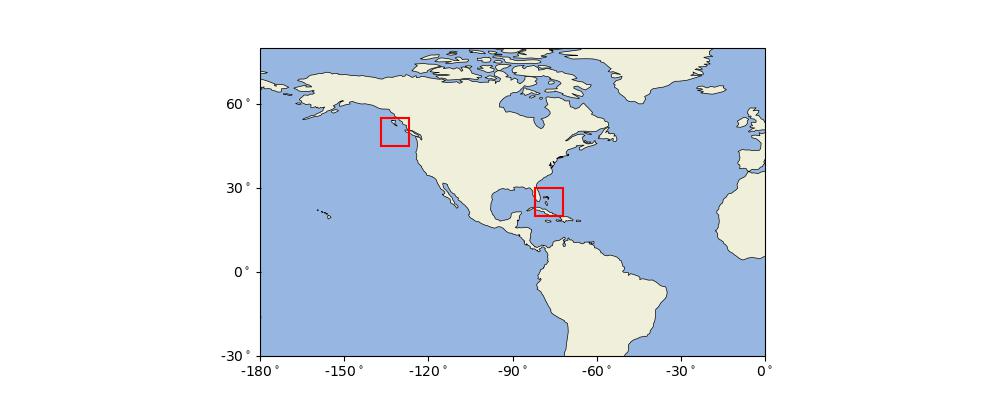


* Spatial means are applied to the SST and anomaly variables, resulting in time series for each region.
* Mean and standard deviation are applied over the time dimension to generate 2D maps for each region.

**Requirements to run this notebook**
* Running from EC2 instance (this notebook was originally run on a c6i.32xlarge)
* have a .netrc file with Earthdata Login credentials on the home directory of the EC2 instance (see Section 1 below).
* In addition to the python modules imported below, the `h5netcdf` and `netCDF4` python modules likely need to be installed (backends used by `xarray`).

In [1]:
import s3fs
import requests

import xarray as xr
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
%matplotlib inline

## 1. Obtain direct S3 access to files

The code in this section requires a `.netrc` file to be in the home directory of the EC2 instance. Place the following lines in the `.netrc` file before continuing:

```
machine urs.earthdata.nasa.gov
    login <Earthdata username>
    password <Earthdata password>
```
<br>

Obtain AWS credentials and use them to connect to the earthdata S3 file system (***access valid for 1 hour***):

In [2]:
creds = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()
fs_s3 = s3fs.S3FileSystem(
    anon=False,
    key=creds['accessKeyId'],
    secret=creds['secretAccessKey'], 
    token=creds['sessionToken'],
    client_kwargs={'region_name':'us-west-2'}
    )

Get S3 paths to all files in the MUR 1 km data set (MUR-JPL-L4-GLOB-v4.1):

In [3]:
s3path = "s3://podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/"
fns = fs_s3.glob(s3path+"*.nc") # list of file paths.

Optional check that files can be accessed and opened with `xarray`. Open one of the files and plot SST's on a subset of the globe:

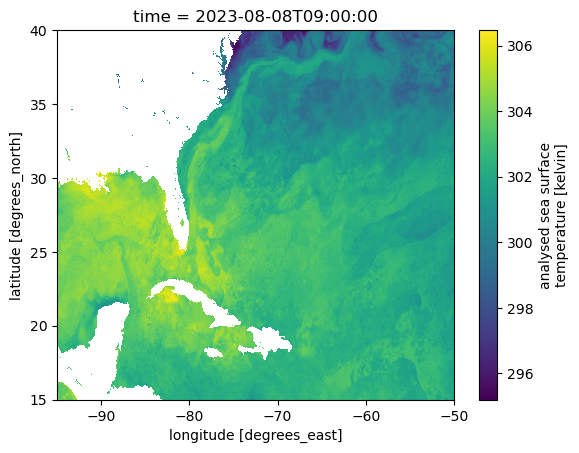

In [4]:
s3_file_obj = fs_s3.open(fns[-1], mode='rb')
sstdata = xr.open_dataset(s3_file_obj)
sstdata['analysed_sst'].sel(lat=slice(15,40), lon=slice(-95, -50)).plot()

## 2. Start Dask cluster

This notebook originally used a c6i.32xlarge instance which has 128 vCPUs. Adjust the `n_workers` argument in the call to `LocalCluster` to match your instance's capabilities

In [5]:
cluster = LocalCluster(n_workers=128)
client = Client(cluster)
# client  # un-comment this line to view cluster information.

## 3. Create mean time series of SST and SST-anomalies for the two regions (aggregation over spatial dimensions)

### 3.1 Open data

Data files (1 file per timestamp) are opened into one dataset using `xarray`'s `open_mfdataset()`. We thin out the number of files to load to 3-day frequency rather than 1-day frequency in the interest of time and the fact that mean SST's over larger regions shouldn't change drastically over a few days.

In [6]:
# Get one out of every 3 files, starting 3 years from the most recent MUR  file:
years_analyze = 3
murfiles_to_load = fns[slice(-1*365*years_analyze, -1, 3)]

**Opening the files with `open_mfdataset()` is the longest step in this process. Once the files are opened, computations are quick.**

In [7]:
%%time

s3_file_objects = [ fs_s3.open(fpath, mode='rb') for fpath in murfiles_to_load ]
murdata = xr.open_mfdataset(
    s3_file_objects, chunks={'time':1, 'lat':6000, 'lon':6000}, 
    drop_variables=['analysis_error','mask','sea_ice_fraction']
    )

murdata['analysed_sst']

CPU times: user 2min 3s, sys: 33.3 s, total: 2min 36s
Wall time: 4min 36s


<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)>
dask.array<concatenate, shape=(365, 17999, 36000), dtype=float32, chunksize=(1, 6000, 6000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-08-05T09:00:00 ... 2023-08-06T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, A...

### 3.2 Compute time series of regional mean SST's and anomalies

Latitude and longitude bounds for each of the regions shown on the map in the notebook intro:

In [8]:
# Sub-tropical western Atlantic region (region 1):
latbnds1 = (20, 30)
lonbnds1 = (-82, -72)

# Mid-latitude eastern Pacific region (region 2):
latbnds2 = (45, 55)
lonbnds2 = (-137, -127)

Function that takes in an `xarray.DataArray` with dimensions of (lat, lon), subsets the data by the input spatial bounds (2-tuples), and takes the subset's mean over the lat/lon dimensions:

In [9]:
def regional_spatial_mean(sstdata, latbnds, lonbnds):
    future_result = sstdata.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    future_result = future_result.mean(dim=['lat','lon'], skipna=True) # mean
    return future_result.load() # Dask syntax. Computations aren't performed until this step!

The computations may throw a `UserWarning: Sending large graph ...` but will complete.

In [10]:
%%time

region1_mean_sst = regional_spatial_mean(murdata['analysed_sst'], latbnds1, lonbnds1)
region2_mean_sst = regional_spatial_mean(murdata['analysed_sst'], latbnds2, lonbnds2)

/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 11.5 s, sys: 2.95 s, total: 14.5 s
Wall time: 22.3 s


In [11]:
%%time

region1_mean_anom = regional_spatial_mean(murdata['sst_anomaly'], latbnds1, lonbnds1)
region2_mean_anom = regional_spatial_mean(murdata['sst_anomaly'], latbnds2, lonbnds2)

/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.68 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 11.6 s, sys: 2.55 s, total: 14.2 s
Wall time: 22.1 s


### 3.3 Plot the results

Text(0, 0.5, 'SST Anomaly [K]')

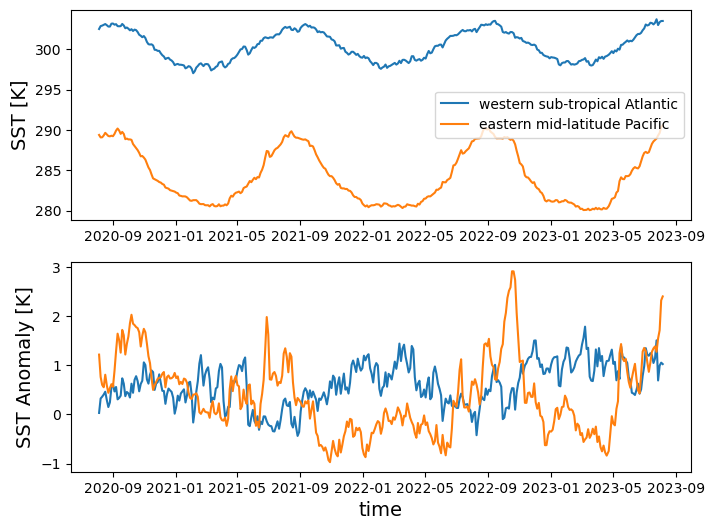

In [12]:
fig1, axes1 = plt.subplots(2, 1, figsize=(8, 6))

axes1[0].plot(region1_mean_sst['time'], region1_mean_sst.values, label='western sub-tropical Atlantic')
axes1[0].plot(region2_mean_sst['time'], region2_mean_sst.values, label='eastern mid-latitude Pacific')

axes1[1].plot(region1_mean_anom['time'], region1_mean_anom.values, label='western sub-tropical Atlantic')
axes1[1].plot(region2_mean_anom['time'], region2_mean_anom.values, label='eastern mid-latitude Pacific')

axes1[0].legend()
axes1[0].set_ylabel('SST [K]', fontsize=14)

axes1[1].set_xlabel('time', fontsize=14)
axes1[1].set_ylabel('SST Anomaly [K]', fontsize=14)

## 4. Create 2D lat-lon maps of SST variability in each region over the past 3 years (aggregation over time dimension)

### 4.1 Rechunk the data to optimize a time-aggregation function

We have already opened the data in the previous section, so the long step is done!

However, now that we are computing along the time dimension, we will want to chunk our data so that chunks cut through the time dimension as little as possible. Note after running the next block of code that the time dimension will have chunk sizes of 20 timestamps rather than 1.

In [13]:
# Chunk sizes of 20 timestamps per chunk:
murdata_timechunked = murdata.chunk({'time':20, 'lat':1000, 'lon':1000})
murdata_timechunked['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 365, lat: 17999, lon: 36000)>
dask.array<rechunk-merge, shape=(365, 17999, 36000), dtype=float32, chunksize=(20, 1000, 1000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-08-05T09:00:00 ... 2023-08-06T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes:
    long_name:      analysed sea surface temperature
    standard_name:  sea_surface_foundation_temperature
    units:          kelvin
    valid_min:      -32767
    valid_max:      32767
    comment:        "Final" version using Multi-Resolution Variational Analys...
    source:         MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTA_G-NAVO, A...

**Note**

Xarray in some cases seems to not want to chunk across the time dimension during the initial call to `open_mfdataset()` (e.g. if we had tried time chunks when first opening the files in Section 3.1). In that case, we could have opened the data first and then rechunked the data afterwards using `chunk()`:


### 4.2 Compute 2D maps of 3-year means and standard deviations for each lat/long location

Similar functions to `regional_spatial_mean()` in Section 3.2, except the mean (first function) or standard deviation (second function) is taken over the time dimension:

In [14]:
def regional_temporal_mean(sstdata, latbnds, lonbnds):
    future_result = sstdata.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    future_result = future_result.mean(dim=['time'], skipna=True) # standard deviation
    return future_result.load()


def regional_temporal_std(sstdata, latbnds, lonbnds):
    future_result = sstdata.sel(lat=slice(*latbnds), lon=slice(*lonbnds)) # subset
    future_result = future_result.std(dim=['time'], skipna=True) # standard deviation
    return future_result.load()

In [15]:
%%time

sstmap1 = regional_temporal_mean(murdata_timechunked['analysed_sst'], latbnds1, lonbnds1)
sstmap2 = regional_temporal_mean(murdata_timechunked['analysed_sst'], latbnds2, lonbnds2)

/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 20.6 s, sys: 5.81 s, total: 26.4 s
Wall time: 34.1 s


In [16]:
%%time

stdmap1 = regional_temporal_std(murdata_timechunked['analysed_sst'], latbnds1, lonbnds1)
stdmap2 = regional_temporal_std(murdata_timechunked['analysed_sst'], latbnds2, lonbnds2)

/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.71 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/distributed/client.py:3125: UserWarning: Sending large graph of size 22.71 MiB.
This may cause some slowdown.
Consider scatt

CPU times: user 16.1 s, sys: 6.71 s, total: 22.8 s
Wall time: 26.8 s


/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/ec2-user/miniconda3/envs/jupyterenv/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


### 4.3 Plot results

Text(0, 0.5, 'SST, 3-year std [K]')

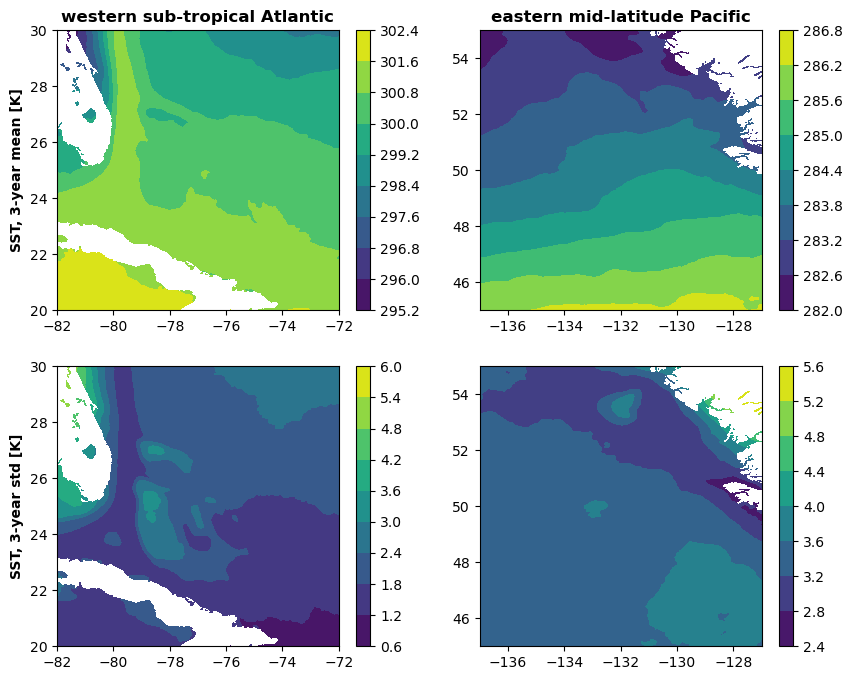

In [17]:
fig2, axes2 = plt.subplots(2, 2, figsize=(10, 8))

# Mean SST maps:
c01 = axes2[0,0].contourf(sstmap1['lon'], sstmap1['lat'], sstmap1.values)
c02 = axes2[0,1].contourf(sstmap2['lon'], sstmap2['lat'], sstmap2.values)
plt.colorbar(c01, ax=axes2[0,0])
plt.colorbar(c02, ax=axes2[0,1])

# SST standard deviation maps:
c11 = axes2[1,0].contourf(stdmap1['lon'], stdmap1['lat'], stdmap1.values)
c12 = axes2[1,1].contourf(stdmap2['lon'], stdmap2['lat'], stdmap2.values)
plt.colorbar(c11, ax=axes2[1,0])
plt.colorbar(c12, ax=axes2[1,1])

axes2[0,0].set_title('western sub-tropical Atlantic', fontweight='bold')
axes2[0,1].set_title('eastern mid-latitude Pacific', fontweight='bold')
axes2[0,0].set_ylabel('SST, %i-year mean [K]' %years_analyze, fontweight='bold')
axes2[1,0].set_ylabel('SST, %i-year std [K]' %years_analyze, fontweight='bold')

## 5. Don't Forget to Close the Client and Cluster!!

In [18]:
client.close()

In [19]:
cluster.close()

## 6. Closing Remarks

* **The longest step by far is opening the collection files with xarray's `open_mfdataset()`. Once the data have been loaded, the sub-sequent computations are relatively quick**. Therefore, code should generally be written to re-open a file as little as possible.
* This also motivates the use of the `kercunk` package, which provides a method (with a little bit of code and preprocessing overhead) to access netCDF files faster.